This notebook comes after `src/data/2-make_dataset.py` and it is covers different sections:
- DATAFRAMES
- REMOVING OUTLIERS
- BALANCING THE DATA
- FEATURE ENGINEERING
- SCALING THE DATA


And after that comes the different models tried:
- DECISION TREE CLASSIFIER
- RANDOM FOREST CLASSIFIER
- XGBOOST
- KNN
- NAIVE BAYES
- SVM
- PCA
- LOGISTIC REGRESSION
- LDA
- NEURAL NETWORK
- VOTING CLASSIFIER
- ADA BOOST
- GRADIENT TREE BOOSTING

Finally, the export of the final dataframes and model
- EXPORTING FINAL DATA AND MODEL

In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
# from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from scipy import stats
import joblib


# DATAFRAMES

In [2]:
df_transformed_1 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed_2 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed_3 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v3_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed_4 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v4_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed_5 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
# df_transformed_6 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v6_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed_7 = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v7_transformed_data_combined_with_nasa.csv", index_col=['index'])

In [33]:
df_transformed_1.columns

Index(['latitude', 'longitude', 'ANN_CLRSKY_SFC_SW_DNI_2009',
       'ANN_CLRSKY_SFC_SW_DNI_2010', 'ANN_TQV_2009', 'ANN_TQV_2010',
       'ANN_WS10M_2009', 'ANN_WS10M_2010', 'autumn_CLRSKY_SFC_SW_DNI_2009',
       'autumn_CLRSKY_SFC_SW_DNI_2010', 'autumn_TQV_2009', 'autumn_TQV_2010',
       'autumn_WS10M_2009', 'autumn_WS10M_2010',
       'spring_CLRSKY_SFC_SW_DNI_2009', 'spring_CLRSKY_SFC_SW_DNI_2010',
       'spring_TQV_2009', 'spring_TQV_2010', 'spring_WS10M_2009',
       'spring_WS10M_2010', 'summer_CLRSKY_SFC_SW_DNI_2009',
       'summer_CLRSKY_SFC_SW_DNI_2010', 'summer_TQV_2009', 'summer_TQV_2010',
       'summer_WS10M_2009', 'summer_WS10M_2010',
       'winter_CLRSKY_SFC_SW_DNI_2009', 'winter_CLRSKY_SFC_SW_DNI_2010',
       'winter_TQV_2009', 'winter_TQV_2010', 'winter_WS10M_2009',
       'winter_WS10M_2010'],
      dtype='object')

In [67]:
df_transformed = df_transformed_1

In [68]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v7_transformed_data_combined_with_nasa.csv", index_col=['index'])
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

<AxesSubplot:>

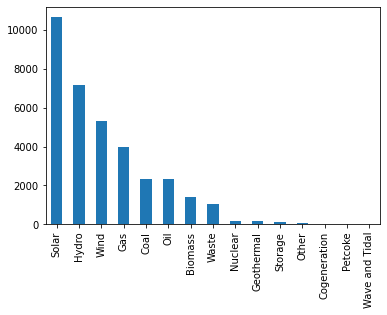

In [69]:
csv_power_plants['primary_fuel'].value_counts().plot.bar()

In [32]:

# index_set_to_delete = csv_power_plants[~csv_power_plants['primary_fuel'].isin(['Solar', 'Wind', 'Gas', 'Coal', 'Oil', 'Nuclear'])].index.tolist()
index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)

# csv_power_plants.filter(like='other_fuel').columns

# csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])]

In [70]:
columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:28260, [columns_to_combine]],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")

In [71]:
columns_delete = df_transformed_combined.columns.str.contains('mean')

df_transformed_combined = df_transformed_combined.loc[:,~columns_delete]

primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

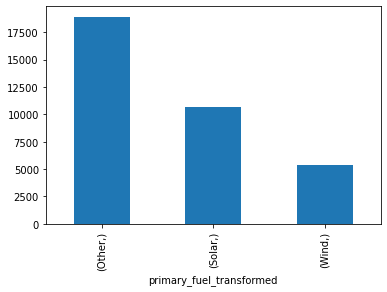

In [72]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [73]:
df_transformed_combined = df_transformed_combined[~(df_transformed_combined['name'].str.contains('CSP') & df_transformed_combined['primary_fuel_transformed'])]

primary_fuel_transformed
Other                       18917
Solar                       10650
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

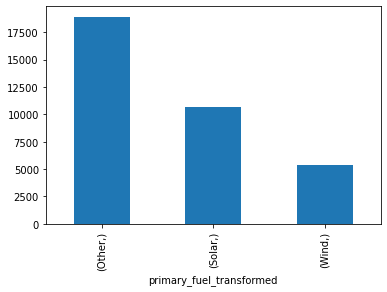

In [74]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [75]:
df_transformed_combined.describe()

,latitude,longitude,ANN_CLRSKY_SFC_SW_DNI_2009,ANN_CLRSKY_SFC_SW_DNI_2010,ANN_TQV_2009,ANN_TQV_2010,ANN_WS10M_2009,ANN_WS10M_2010,autumn_CLRSKY_SFC_SW_DNI_2009,autumn_CLRSKY_SFC_SW_DNI_2010,...,winter_WS10M_2009,winter_WS10M_2010,capacity_mw,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019
count,34921.000000,34921.000000,34921.000000,34921.000000,34921.000000,34921.000000,34921.000000,34921.000000,34921.000000,34921.000000,...,34921.000000,34921.000000,34921.000000,6416.000000,7225.000000,8202.000000,9143.000000,9499.000000,9636.000000,9657.000000
mean,32.823123,-6.981838,7.149391,7.269546,20.529507,20.728590,3.733234,3.707632,7.228128,7.386877,...,3.618859,3.705289,163.368215,592.787824,656.954221,762.461277,693.225105,661.903398,517.374051,424.009683
std,22.634084,78.406172,1.190324,1.191355,9.650866,9.758008,1.199616,1.138412,2.138001,2.123174,...,1.287606,1.297038,489.714777,2174.990576,2231.605519,2533.600450,2404.637471,2369.412069,1975.398268,1698.671556
min,-77.847000,-179.977700,3.750000,3.650000,2.020000,1.840000,0.580000,0.550000,1.010000,0.940000,...,0.540000,0.510000,1.000000,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000,-982.622000,-780.339000
25%,29.260000,-77.642600,6.460000,6.610000,14.880000,15.050000,2.840000,2.880000,5.586667,5.620000,...,2.643333,2.720000,4.900000,1.945000,2.260000,2.664250,2.729000,2.465000,2.242000,2.758000
50%,39.734000,-2.127000,7.170000,7.390000,17.020000,17.120000,3.710000,3.720000,7.540000,7.673333,...,3.596667,3.726667,16.700000,23.439000,23.668000,26.193000,22.462778,17.877000,12.530500,11.536000
75%,46.265900,49.470000,7.830000,7.940000,24.270000,24.550000,4.600000,4.500000,8.926667,9.026667,...,4.506667,4.613333,75.200000,199.779500,226.366000,285.901792,249.922500,214.528100,151.184000,122.795000
max,71.292000,179.388700,11.720000,11.720000,58.230000,59.660000,8.420000,7.950000,18.396667,18.166667,...,8.826667,9.526667,22500.000000,50834.000000,32320.917000,37433.607000,32377.477000,36448.643000,35136.000000,31920.368000


In [76]:
# df_transformed_combined = df_transformed_combined.loc[df_transformed_combined['generation_gwh_2013'].notna() & df_transformed_combined['generation_gwh_2014'].notna() & df_transformed_combined['generation_gwh_2015'].notna() & df_transformed_combined['generation_gwh_2016'].notna() & df_transformed_combined['generation_gwh_2017'].notna() & df_transformed_combined['generation_gwh_2018'].notna() & df_transformed_combined['generation_gwh_2019'].notna()]

primary_fuel_transformed
Other                       18917
Solar                       10650
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

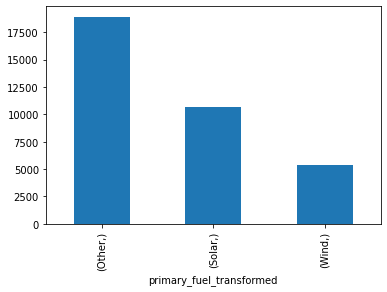

In [77]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [78]:
label_encoder = LabelEncoder()
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
df_transformed_combined = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'].notna()]
df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


In [79]:
df_target_equivalent = df_transformed_combined[['primary_fuel_transformed', 'code_prim_fuel_transf']].drop_duplicates()
df_target_equivalent = df_target_equivalent.set_index('code_prim_fuel_transf').sort_index().reset_index().drop(columns=['code_prim_fuel_transf'])
list_target_in_order = df_target_equivalent.squeeze().to_list()

# REMOVING OUTLIERS

In [47]:

# columns_not_consider_outliers = [
#                                     'name',
#                                     'capacity_mw',
#                                     'latitude',
#                                     'longitude',
#                                     'primary_fuel_transformed',
#                                     'code_prim_fuel_transf',
#                                     'generation_gwh_2013',
#                                     'generation_gwh_2014',
#                                     'generation_gwh_2015',
#                                     'generation_gwh_2016',
#                                     'generation_gwh_2017',
#                                     'generation_gwh_2018',
#                                     'generation_gwh_2019'
#                                 ]
# # X = X.loc[:,~columns_delete]                        
# df_transformed_combined_remove_outliers = df_transformed_combined.drop(columns = columns_not_consider_outliers)

In [48]:
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(df_transformed_combined_remove_outliers)

In [49]:
# # # select all rows that are outliers
# mask = yhat == -1
# index_outliers = df_transformed_combined[mask].index

In [50]:
# # WITH OUTLIERS
# print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
# df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [51]:
# # WITHOUT OUTLIERS
# df_transformed_combined.drop(index_outliers, axis=0, inplace =True)

# print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
# df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

# BALANCING THE DATA

In [52]:
utils.balancing_data_more_than_1000(df_transformed_combined, 'primary_fuel_transformed')

<AxesSubplot:xlabel='primary_fuel_transformed'>

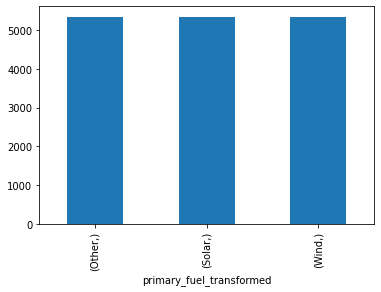

In [53]:
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [54]:
df_transformed_combined.isna().sum()

latitude                             0
longitude                            0
ANN_CLRSKY_SFC_SW_DNI_2009           0
ANN_CLRSKY_SFC_SW_DNI_2010           0
ANN_TQV_2009                         0
ANN_TQV_2010                         0
ANN_WS10M_2009                       0
ANN_WS10M_2010                       0
autumn_CLRSKY_SFC_SW_DNI_2009        0
autumn_CLRSKY_SFC_SW_DNI_2010        0
autumn_TQV_2009                      0
autumn_TQV_2010                      0
autumn_WS10M_2009                    0
autumn_WS10M_2010                    0
spring_CLRSKY_SFC_SW_DNI_2009        0
spring_CLRSKY_SFC_SW_DNI_2010        0
spring_TQV_2009                      0
spring_TQV_2010                      0
spring_WS10M_2009                    0
spring_WS10M_2010                    0
summer_CLRSKY_SFC_SW_DNI_2009        0
summer_CLRSKY_SFC_SW_DNI_2010        0
summer_TQV_2009                      0
summer_TQV_2010                      0
summer_WS10M_2009                    0
summer_WS10M_2010        

In [55]:
# index_to_drop = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'] == 'Wind'].index
# df_transformed_combined.drop(index_to_drop, inplace=True)
# X = X.loc[:,~columns_delete]

In [84]:
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
columns_to_drop = [
                        'name',
                        'capacity_mw',
                        'latitude',
                        'longitude',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
df_transformed_combined.drop(columns=columns_to_drop, inplace = True)
# pre_X.dropna(inplace = True)
X = df_transformed_combined.drop(columns=['code_prim_fuel_transf'])
y = df_transformed_combined['code_prim_fuel_transf']

In [57]:
y.value_counts()

1    5344
0    5344
2    5344
Name: code_prim_fuel_transf, dtype: int64

In [ ]:
df_transformed_combined.columns

# DIFFERENT DATASETS

In [ ]:
#  columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('MIN')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('2019') | X.columns.str.contains('2012') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('MIN') | X.columns.str.contains('ANN')
# columns_delete = X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('ANN') #| X.columns.str.contains('WS50M_RANGE_AVG') | X.columns.str.contains('WS10M_RANGE_AVG') | X.columns.str.contains('CLRSKY_SFC_SW_UP') | X.columns.str.contains('CLRSKY_SFC_SW_DNI') | X.columns.str.contains('CLRSKY_SFC_SW_DIFF') | X.columns.str.contains('ALLSKY_SFC_SW_UP_MAX') | X.columns.str.contains('ALLSKY_SFC_SW_DNI') | X.columns.str.contains('ALLSKY_SFC_LW_UP') | X.columns.str.contains('ALLSKY_SFC_LW_DWN') | X.columns.str.contains('ALLSKY_SFC_SW_UP') | X.columns.str.contains('ALLSKY_SFC_SW_DIFF')
# columns_keep = X.columns.str.contains('ANN') | X.columns.str.contains('SFC_LW_DWN') | X.columns.str.contains('2013')| X.columns.str.contains('MAX')
# columns_delete = X.columns.str.contains('WS') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')
# columns_keep_2012 =  X.columns.str.contains('2012')
X_columns_keep_2013 =  X.columns.str.contains('2013')
X_columns_keep_2014 =  X.columns.str.contains('2014')
columns_keep_2013 =  df_transformed_combined.columns.str.contains('2013') | df_transformed_combined.columns.str.contains('prim_fuel')
columns_keep_2014 =  df_transformed_combined.columns.str.contains('2014') | df_transformed_combined.columns.str.contains('prim_fuel')
# columns_keep = mi_scores[mi_scores > .3].index
# columns_delete = X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') 
# columns_delete = X.columns.str.contains('WS50M_2013') | X.columns.str.contains('WS10') | X.columns.str.contains('DNI') | X.columns.str.contains('SFC_LW_UP') | X.columns.str.contains('SFC_SW_DWN') | X.columns.str.contains('autumn') | X.columns.str.contains('winter') | X.columns.str.contains('summer') | X.columns.str.contains('spring') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')
# columns_delete = X.columns.str.contains('WS50M_2013') | X.columns.str.contains('WS10') | X.columns.str.contains('autumn') | X.columns.str.contains('winter') | X.columns.str.contains('summer') | X.columns.str.contains('spring') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')

# X_2012 = X.loc[:,columns_keep_2012]
X_2013 = X.loc[:,X_columns_keep_2013]
X_2014 = X.loc[:,X_columns_keep_2014]
df_transformed_combined_2013 = df_transformed_combined.loc[:,columns_keep_2013]
df_transformed_combined_2014 = df_transformed_combined.loc[:,columns_keep_2014]
# X = X.loc[:,~columns_delete]

In [ ]:
# X_columns_delete_2014 = X_2014.columns.str.contains('RANGE') | X_2014.columns.str.contains('MAX_AVG') | X_2014.columns.str.contains('median')
# columns_delete_2014 = df_transformed_combined_2014.columns.str.contains('RANGE') | df_transformed_combined_2014.columns.str.contains('MAX_AVG') | df_transformed_combined_2014.columns.str.contains('median')

# X_2014 = X_2014.loc[:,~X_columns_delete_2014]

# df_transformed_combined_2014 = df_transformed_combined_2014.loc[:,~columns_delete_2014]

In [ ]:
df_transformed_combined_2014.columns

# FEATURE ENGINEERING

## Mutual Information

In [ ]:
mi_scores = utils.make_mi_scores(X_2014, y, "classifier")


In [ ]:
plt.figure(dpi=100, figsize=(8, 30))
utils.plot_scores(mi_scores[mi_scores > .3], "Mutual Information Scores")

## Pearson correlations

In [ ]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()


corr_matrix = df_transformed_combined_2014.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_transformed_combined_2014.drop(columns=to_drop, inplace=True)

In [ ]:
# plt.bar(df_all_concat_annual.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_all_concat_annual.columns)
corr_matrix = df_transformed_combined_2014.corr().abs()



target_correlations = corr_matrix.unstack()['code_prim_fuel_transf'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations[target_correlations > .30]
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [ ]:
target_correlations[target_correlations > .20].index

In [ ]:
# sns.pairplot(df_transformed_combined_2014[target_correlations[target_correlations > .20].index])

In [ ]:
# CLRSKY_SFC_SW_DNI

# category = pd.cut(df_transformed_combined_2014['max_CLRSKY_SFC_SW_DWN_2014'], 3).cat.codes.rename('category')

In [ ]:
# category.value_counts()

In [ ]:
# df_all_concat_w_category = pd.concat([df_transformed_combined_2014[target_correlations[target_correlations > .20].index], category], axis=1)

In [ ]:
# sns.pairplot(df_all_concat_w_category, hue='category')

In [ ]:
# mi_scores = utils.make_mi_scores(X, y, "classifier")
# plt.figure(dpi=100, figsize=(8, 30))
# utils.plot_scores(mi_scores, "Mutual Information Scores")

In [ ]:
utils.correlation_matrix(df_transformed_combined_2014)

In [ ]:
# corr_matrix = X.join(y).corr().abs()



# target_correlations = corr_matrix.unstack()['code_prim_fuel_transf'].sort_values(ascending=False)
# # target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# # target_correlations[target_correlations > .20]
# plt.figure(figsize=(20,10))
# # plt.figure(dpi=100, figsize=(4, 10))
# utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [ ]:
df_transformed_combined

In [85]:
# df_all_concat_w_category

X = df_transformed_combined.drop(columns=['code_prim_fuel_transf'])
# X = df_transformed_combined_2014[mi_scores[mi_scores > .3].index]
# X = df_transformed_combined_2014[target_correlations[target_correlations > .20].index].drop(columns=['code_prim_fuel_transf'])
# X = df_all_concat_w_category.drop(columns=['code_prim_fuel_transf'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_transformed_combined['code_prim_fuel_transf']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# SCALING

In [87]:
# X_train_normalized = stats.boxcox(X_train)
x = X_train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled, index=X_train.index, columns=X_train.columns)

x = X_test.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_test_scaled = pd.DataFrame(x_scaled, index=X_test.index, columns=X_test.columns)

x = X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)


# DECISION TREE CLASSIFIER

1200


<AxesSubplot:>

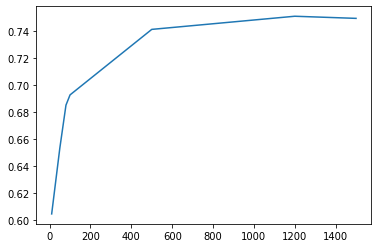

In [88]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}

results = {node: utils.get_accuracy_tree("classifier",node, X_train, X_test, y_train, y_test) for node in candidate_max_leaf_nodes}
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

Cross validation:
[75.25 76.17 76.12 75.35 75.67](%)
Mean: 75.71%, Standard Deviation: 0.38%
Hold Out:
75.64%
              precision    recall  f1-score   support

       Other       0.81      0.81      0.81      3755
       Solar       0.71      0.71      0.71      2160
        Wind       0.68      0.68      0.68      1068

    accuracy                           0.76      6983
   macro avg       0.73      0.73      0.73      6983
weighted avg       0.76      0.76      0.76      6983



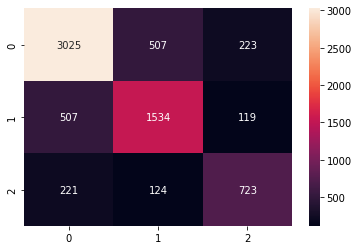

In [89]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
utils.custom_classification_prediction_report(tree_model, X, y, X_test, y_test, list_target_in_order)

In [ ]:
importance = tree_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {X_train.columns[i]}, Score: {np.around(v*100,2)} %')
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(30,20))
plt.bar([X_train.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# RANDOM FOREST CLASSIFIER

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]


param_grid = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [ ]:
rf_model = RandomForestClassifier(random_state=0)
# rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=3, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 150, cv=5, verbose = 2, n_jobs=4)

In [ ]:
rf_grid.fit(X_train, y_train)

In [ ]:
rf_grid.best_params_

In [ ]:
rf_grid.score(X_test, y_test)
# rf_grid.score(X_test_scaled_pca, y_test)

In [65]:
rf_model2 = RandomForestClassifier(bootstrap= False,
 max_depth= 420,
 min_samples_leaf= 1,
 min_samples_split= 20,
 n_estimators= 20,
 max_leaf_nodes= 490)
# rf_model2 = RandomForestClassifier()

rf_model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=420, max_leaf_nodes=490,
                       min_samples_split=20, n_estimators=20)

Cross validation:
[75.3  76.68 74.36 74.17 77.23](%)
Mean: 75.55%, Standard Deviation: 1.22%
Hold Out:
75.4%
              precision    recall  f1-score   support

       Other       0.75      0.67      0.71      1072
       Solar       0.74      0.77      0.76      1100
        Wind       0.77      0.83      0.80      1035

    accuracy                           0.75      3207
   macro avg       0.75      0.75      0.75      3207
weighted avg       0.75      0.75      0.75      3207



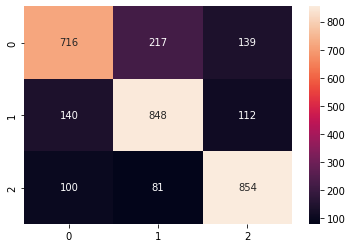

In [66]:
utils.custom_classification_prediction_report(rf_model2, X, y, X_test, y_test, list_target_in_order)

In [ ]:
utils.learning_curve_plot("Random Forest", rf_model2, X_train, y_train)

In [ ]:
importance = rf_model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {X_train.columns[i]}, Score: {np.around(v*100,2)} %')
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(30,10))
plt.bar([X_train.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# XGBOOST

In [ ]:
xgbclass_model_1 = XGBClassifier()
xgbclass_model_1.fit(X_train, y_train)
# xgbclass_model_1.fit(X_train_scaled_pca, y_train)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
param_grid = {
                'n_estimators': [5,10,50,100,500],
                'learning_rate': [0.001,0.01,0.05,0.1,0.2],
                'max_depth': [2,4,6],
                'gamma': [0.0,0.1,0.2],
                'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
            }

In [ ]:
# xgb_grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv=4, verbose = 2, n_jobs=4)
xgb_grid = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_grid, n_iter = 30, cv=5, verbose = 1, n_jobs=4)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_grid.score(X_test, y_test)

In [ ]:
xgb_grid.best_params_

In [ ]:
xgbclass_model_2 = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.2, gamma=0.0, colsample_bytree = 0.5, n_jobs=4)
xgbclass_model_2.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_2, X, y, X_test, y_test, list_target_in_order)

# KNN

In [ ]:
candidate_n_neighbors = np.arange(1,31)
results = {}

results = {n: utils.get_accuracy_knn("classifier",n, X_train, X_test, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
knn_model_1 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_1.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(knn_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
candidate_n_neighbors = np.arange(1,25)
results = {}

results = {n: utils.get_accuracy_knn("classifier",n, X_train_scaled, X_test_scaled, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
knn_model_2 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_2.fit(X_train_scaled, y_train)

In [ ]:
utils.custom_classification_prediction_report(knn_model_2, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# NAIVE BAYES

In [ ]:
nb_model_1 = GaussianNB()
nb_model_1.fit(X_train, y_train)

utils.custom_classification_prediction_report(nb_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
nb_model_2 = GaussianNB()
nb_model_2.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(nb_model_2, X_scaled, y, X_test, y_test, list_target_in_order)

# SVM

In [ ]:
svm_model_1 = SVC(decision_function_shape='ovo')
svm_model_1.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(svm_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
param_grid = {
                'C': [0.5, 1, 10, 100], # NOTE: values for C must be > 0
                'gamma': ['scale', 1, .1, .01, .001, .0001],
                'kernel': ['rbf', 'linear'], # Some linear fittings last to 7/8 mins. Not recommended at all
                'decision_function_shape': ['ovo', 'ovr']
            }
# svm_grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
svm_grid = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid, cv=5, verbose = 2, n_jobs=4)

In [ ]:
svm_grid.fit(X_train_scaled, y_train)

In [ ]:
svm_grid.best_params_

In [ ]:
svm_grid.score(X_test_scaled, y_test)

In [ ]:
svm_model_2 = SVC(C= 10, gamma= 0.1, kernel='rbf', decision_function_shape= 'ovo')
svm_model_2.fit(X_train_scaled, y_train)
utils.custom_classification_prediction_report(svm_model_2, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# PCA

In [ ]:
pca = PCA(n_components=3)
pca.fit(X_train_scaled)

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Decision tree with PCA

In [ ]:
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
X_scaled_pca = pca.transform(X_scaled)

candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}

results = {node: utils.get_accuracy_tree("classifier",node, X_train_scaled_pca, X_test_scaled_pca, y_train, y_test) for node in candidate_max_leaf_nodes}
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())


In [ ]:
tree_model = DecisionTreeClassifier(max_leaf_nodes = best_tree_size, random_state=0)
tree_model.fit(X_train_scaled_pca, y_train)

In [ ]:
utils.custom_classification_prediction_report(tree_model, X_scaled_pca, y, X_test_scaled_pca, y_test, list_target_in_order)

# LOGISTIC REGRESSION

In [ ]:
logistic_model_1 = LogisticRegression(multi_class= 'ovr')
logistic_model_1.fit(X_train_scaled, y_train)
utils.custom_classification_prediction_report(logistic_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# LDA & QDA

In [ ]:
lda = LDA(n_components = 2)
X_train_scaled_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_scaled_lda = lda.transform(X_test_scaled)
X_scaled_lda = lda.transform(X_scaled)

In [ ]:
lda.fit(X_train_scaled_lda, y_train)
utils.custom_classification_prediction_report(lda, X_scaled_lda, y, X_test_scaled_lda, y_test, list_target_in_order)

In [ ]:
lda_2 = LDA()
lda_2.fit(X_train_scaled, y_train)
utils.custom_classification_prediction_report(lda_2, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

In [ ]:
qda = QDA()
qda.fit(X_train, y_train)
utils.custom_classification_prediction_report(qda, X, y, X_test, y_test, list_target_in_order)

# NEURAL NETWORK

In [ ]:
nn_model_1 = MLPClassifier(max_iter=300)
nn_model_1.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(nn_model_1, X, y, X_test, y_test, list_target_in_order)

# BAGGING CLASSIFIER

In [ ]:
bag_model_1 = BaggingClassifier(
    base_estimator = RandomForestClassifier(
                        bootstrap=False, 
                        max_depth=420, 
                        max_leaf_nodes=490,
                       min_samples_split=20, 
                       n_estimators=20
                       ), 
    n_estimators=50)
    
bag_model_1.fit(X_train, y_train)
utils.custom_classification_prediction_report(bag_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:

bag_model_2 = BaggingClassifier(
    base_estimator = SVC(
                            C= 10, 
                            gamma= 0.1, 
                            kernel='rbf', 
                            decision_function_shape= 'ovo'
                        ), 
    n_estimators=10)
    
bag_model_2.fit(X_train_scaled, y_train)
utils.custom_classification_prediction_report(bag_model_2, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

In [ ]:
classifier = {
        'KNeighbors': KNeighborsClassifier(n_neighbors=3),
        'DecisionTree': DecisionTreeClassifier(max_leaf_nodes=500),
        'XGBClassifier': XGBClassifier()
    }

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=10).fit(X_train_scaled, y_train)
    
    bag_pred = bag_class.predict(X_test_scaled)
    
    results_cv = cross_val_score(bag_class, X_scaled, y, cv=StratifiedKFold(shuffle = True))
    
    print(f'Accuracy Bagging with {name}: {accuracy_score(bag_pred, y_test)}')
    print('')
    print(f'Mean: {results_cv.mean()}, Standard Deviation: {results_cv.std()}')
    print('')

# VOTING CLASSIFIER

In [ ]:


votclass_model_1 = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=3)), 
    ('svc', SVC(C= 10, gamma= 0.1, kernel='rbf', decision_function_shape= 'ovo')), 
    ('rf', RandomForestClassifier(bootstrap= False,
        max_depth= 420,
        min_samples_leaf= 1,
        min_samples_split= 20,
        n_estimators= 20,
        max_leaf_nodes= 490))
], voting='hard')
votclass_model_1.fit(X_train, y_train)

utils.custom_classification_prediction_report(votclass_model_1, X, y, X_test, y_test, list_target_in_order)

# ADABOOST

In [ ]:
adaBoost_model_1 = AdaBoostClassifier()
adaBoost_model_1.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(adaBoost_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# GRADIENT TREE BOOSTING

In [ ]:
gradboost_model_1 = GradientBoostingClassifier()
gradboost_model_1.fit(X_train, y_train)

utils.custom_classification_prediction_report(gradboost_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]

learning_rate = [np.around(x,3) for x in np.arange(0.005, 2.001, 0.005)]

warm_start = [True, False]

n_iter_no_change = [5, 10 , None]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]


param_grid_gbc = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'warm_start': warm_start,
                'max_leaf_nodes': max_leaf_nodes,
                'n_iter_no_change': n_iter_no_change,
                'learning_rate': learning_rate
            }


In [ ]:
gbc_model = GradientBoostingClassifier(random_state=0)
# rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=3, verbose = 2, n_jobs=4)
gbc_grid = RandomizedSearchCV(estimator = gbc_model, param_distributions = param_grid_gbc, n_iter = 30, cv=5, verbose = 2, n_jobs=4)

In [ ]:
# rf_grid.fit(X_train_scaled_pca, y_train)
gbc_grid.fit(X_train, y_train)

In [ ]:
gbc_grid.best_params_

In [ ]:
gbc_grid.score(X_test, y_test)
# rf_grid.score(X_test_scaled_pca, y_test)

In [ ]:
gbc_grid.best_estimator_

In [ ]:
gradboost_model_2 = GradientBoostingClassifier(learning_rate=0.07, max_depth=20, max_leaf_nodes=100,
                           min_samples_leaf=90, min_samples_split=40,
                           n_estimators=80, random_state=0, warm_start=True)
gradboost_model_2.fit(X_train, y_train)                        
utils.custom_classification_prediction_report(gradboost_model_2, X, y, X_test, y_test, list_target_in_order)

# EXPORTING FINAL DATA AND MODEL

In [ ]:
X.to_csv(utils.DIR_DATA_PROCESSED/"classification_X.csv")
y.to_csv(utils.DIR_DATA_PROCESSED/"classification_y.csv")
df_target_equivalent.to_csv(utils.DIR_DATA_PROCESSED/"classification_y_real_values.csv")

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_2, X, y, X_test, y_test, list_target_in_order)

In [ ]:
joblib.dump(xgbclass_model_1, utils.DIR_MODELS/"xgbclass_model_1.pkl")

In [ ]:
y_test.value_counts()